# How to (properly) include p-values with sklearn

## Import the relevant libraries

In [2]:
# For these lessons we will need NumPy, pandas, matplotlib and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()

# and of course the actual regression (machine learning) module
from sklearn import linear_model

## Load the data

In [4]:
# Load the data from a .csv in the same folder
data = pd.read_csv('Concord.csv')

# Let's explore the top 5 rows of the df
data.head()

,case,water81,water80,water79,income,educat,retire,peop81,cpeop,peop80
0,5,2300,3500,3500.0,35,18,0,3,0,3
1,6,2500,4600,4100.0,60,20,0,5,0,5
2,7,4000,3800,5500.0,30,16,0,6,1,5
3,8,500,1500,1700.0,20,11,1,1,-1,2
4,9,4400,4300,3700.0,50,20,0,2,0,2


In [5]:
# This method gives us very nice descriptive statistics. We don't need this for now, but will later on!
data.describe()

,case,water81,water80,water79,income,educat,retire,peop81,cpeop,peop80
count,496.000000,496.000000,496.000000,449.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,260.364919,2298.387097,2732.056452,2974.164811,23.076613,14.004032,0.294355,3.072581,-0.038306,3.110887
std,147.914861,1486.123498,1763.800020,1895.683720,13.057842,3.090550,0.456212,1.657177,0.484658,1.658100
min,5.000000,100.000000,200.000000,200.000000,2.000000,6.000000,0.000000,1.000000,-3.000000,1.000000
25%,133.750000,1200.000000,1500.000000,1700.000000,15.000000,12.000000,0.000000,2.000000,0.000000,2.000000
50%,259.500000,2050.000000,2300.000000,2500.000000,21.000000,13.000000,0.000000,3.000000,0.000000,3.000000
75%,386.250000,2900.000000,3700.000000,3800.000000,30.000000,16.000000,1.000000,4.000000,0.000000,4.000000
max,516.000000,10100.000000,12700.000000,14500.000000,100.000000,20.000000,1.000000,10.000000,3.000000,10.000000


## Create your first multiple regression

### Declare the dependent and independent variables

In [6]:
# There are two independent variables: 'SAT' and 'Rand 1,2,3'
x = data.iloc[:,2:9].drop('water79', axis=1)

# and a single depended variable: 'GPA'
y = data['water81']

## How to (properly) include p-values in sklearn

In [7]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [8]:
# When we create the regression everything is the same
reg_with_pvalues = LinearRegression()
reg_with_pvalues.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# The difference is that we can check what's contained in the local variable 'p' in an instance of the LinearRegression() class
reg_with_pvalues.p

array([0.00000000e+00, 2.65243738e-09, 9.67258069e-08, 2.91861270e-02,
       0.00000000e+00, 2.30479988e-01])

In [10]:
# Let's create a new data frame with the names of the features
reg_summary = pd.DataFrame(x.columns,columns =['Features'])
# Then we create and fill a second column, called 'Coefficients' with the coefficients of the regression
reg_summary['Coefficients'] = reg_with_pvalues.coef_
# Finally, we add the p-values we just calculated
reg_summary['p-values'] = reg_with_pvalues.p.round(3)

In [11]:
# This result is identical to the one from StatsModels
reg_summary

,Features,Coefficients,p-values
0,water80,0.491940,0.000
1,income,20.966992,0.000
2,educat,-41.865519,0.000
3,retire,189.184328,0.029
4,peop81,248.197019,0.000
5,cpeop,96.453603,0.230


In [12]:
x2 = x.drop('cpeop', axis=1)

In [13]:
# When we create the regression everything is the same
reg_with_pvalues2 = LinearRegression()
reg_with_pvalues2.fit(x2,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
# Let's create a new data frame with the names of the features
reg_summary2 = pd.DataFrame(x2.columns,columns =['Features'])
# Then we create and fill a second column, called 'Coefficients' with the coefficients of the regression
reg_summary2['Coefficients'] = reg_with_pvalues2.coef_
# Finally, we add the p-values we just calculated
reg_summary2['p-values'] = reg_with_pvalues2.p.round(3)

In [15]:
reg_summary2

,Features,Coefficients,p-values
0,water80,0.487501,0.000
1,income,21.294277,0.000
2,educat,-42.192765,0.000
3,retire,189.260113,0.029
4,peop81,253.990038,0.000


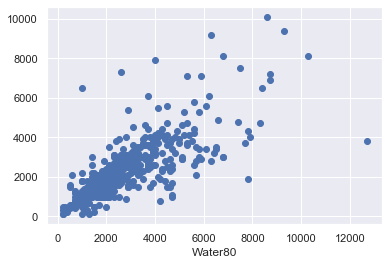

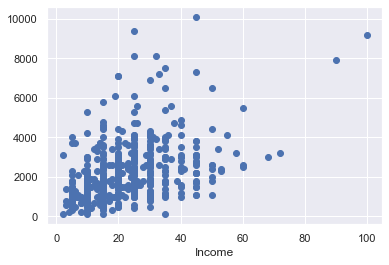

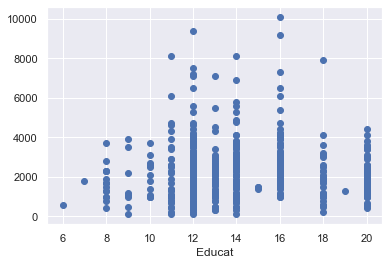

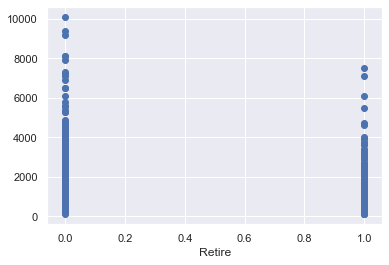

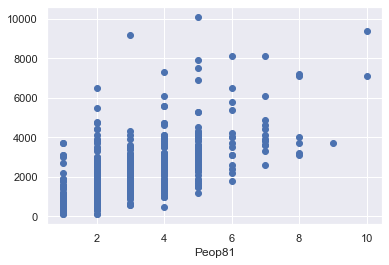

In [17]:
colnum = 10
for r in range(len(x2.columns)):
    plt.scatter(x=x2.iloc[:,r],y=y)
#    plt.scatter(reg_with_pvalues2.)
    plt.xlabel(str(x2.columns[r]).title())
    plt.show()

In [ ]:
colnum = 10
for r in range(len(x2.columns)):
    plt.scatter(x=x2.iloc[:,r],y=y)
    plt.xlabel(str(x2.columns[r]).title())
plt.show()